In [ ]:
from brian2 import *

import plot_utils as pu

seed(11922)  # to get identical figures for repeated runs

# Parameters 

In [11]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = 1.0*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 3200             # Number of excitatory neurons
N_i = 800              # Number of inhibitory neurons

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 9.99*nS          # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -80*mV           # Inhibitory synaptic reversal potential
C_m = 198*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 10*ms          # Inhibitory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 150*pA          # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
w_i = 1.0*nS           # Inhibitory synaptic conductance
U_0 = 0.6              # Synaptic release probability at rest
Omega_d = 2.0/second   # Synaptic depression rate
Omega_f = 3.33/second  # Synaptic facilitation rate

defaultclock.dt = sim_dt

# Neurons

In [12]:
### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic inh. conductance
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]

## Synapses


In [13]:
synapses_eqs = '''
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')

exc_syn.connect(p=0.05)
inh_syn.connect(p=0.2)
# neurotransmitter resources
exc_syn.x_S = 1
inh_syn.x_S = 1


# Monitors and plots
## for the 2.3 part of paper

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s


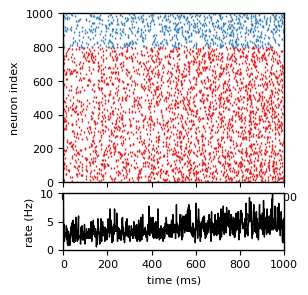

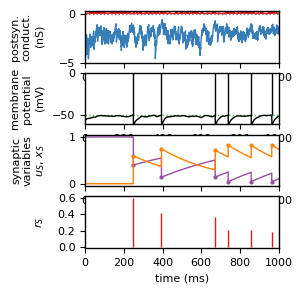

In [14]:
# Monitor setup
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)

ni = 50
state_mon = StateMonitor(exc_neurons, ['v', 'g_e', 'g_i'], record=ni)

synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[ni, :], when='after_synapses')

run(duration, report='text')

# Analysis and plotting
import sympy

### Spiking activity (w/ rate)
fig1, ax = plt.subplots(nrows=2, ncols=1, sharex=False,
                        gridspec_kw={'height_ratios': [3, 1],
                                     'left': 0.18, 'bottom': 0.18, 'top': 0.95,
                                     'hspace': 0.1},
                        figsize=(3.07, 3.07))
ax[0].plot(exc_mon.t[exc_mon.i <= N_e//4]/ms,
           exc_mon.i[exc_mon.i <= N_e//4], '|', color='C0')
ax[0].plot(inh_mon.t[inh_mon.i <= N_i//4]/ms,
           inh_mon.i[inh_mon.i <= N_i//4]+N_e//4, '|', color='C1')
ax[0].set(xlim=(0.,duration/ms), ylim=(0,(N_e+N_i)//4), ylabel='neuron index')

# Generate frequencies
bin_size = 1*ms
spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/ms, inh_mon.t/ms],
                                    int(duration/ms))
rate = double(spk_count)/(N_e + N_i)/bin_size/Hz
ax[1].plot(bin_edges[:-1], rate, '-', color='k')
ax[1].set(xlim=(0.,duration/ms), ylim=(0, 10.),
          xlabel='time (ms)', ylabel='rate (Hz)')

### Dynamics of a single neuron
fig2, ax = plt.subplots(4, sharex=False,
                       gridspec_kw={'left': 0.27, 'bottom': 0.18, 'top': 0.95,
                                    'hspace': 0.2},
                       figsize=(3.07, 3.07))
### Postsynaptic conductances
ax[0].plot(state_mon.t/ms, state_mon.g_e[0]/nS, color='C0')
ax[0].plot(state_mon.t/ms, -state_mon.g_i[0]/nS, color='C1')
ax[0].plot([state_mon.t[0]/ms, state_mon.t[-1]/ms], [0, 0], color='grey',
           linestyle=':')
# Adjust axis
ax[0].set(xlim=(0., duration/ms), ylim=(-5.0,0.25),
          ylabel='postsyn.\nconduct.\n(${0}$)'.format(sympy.latex(nS)))

### Membrane potential
ax[1].axhline(V_th/mV, color='C2', linestyle=':')  # Threshold
# Artificially insert spikes
ax[1].plot(state_mon.t/ms, state_mon.v[0]/mV, color='black')
ax[1].vlines(exc_mon.t[exc_mon.i == ni]/ms, V_th/mV, 0, color='black')
ax[1].set(xlim=(0., duration/ms), ylim=(-1+V_r/mV,0.),
          ylabel='membrane\npotential\n(${0}$)'.format(sympy.latex(mV)))

### Synaptic variables
# Retrieves indexes of spikes in the synaptic monitor using the fact that we
# are sampling spikes and synaptic variables by the same dt
spk_index = np.in1d(synapse_mon.t, exc_mon.t[exc_mon.i == ni])
ax[2].plot(synapse_mon.t[spk_index]/ms, synapse_mon.x_S[0][spk_index], '.',
           ms=4, color='C3')
ax[2].plot(synapse_mon.t[spk_index]/ms, synapse_mon.u_S[0][spk_index], '.',
           ms=4, color='C4')

time = synapse_mon.t  # time vector
tspk = Quantity(synapse_mon.t, copy=True)  # Spike times
for ts in exc_mon.t[exc_mon.i == ni]:
    tspk[time >= ts] = ts
ax[2].plot(synapse_mon.t/ms, 1 + (synapse_mon.x_S[0]-1)*exp(-(time-tspk)*Omega_d),
           '-', color='C3')
ax[2].plot(synapse_mon.t/ms, synapse_mon.u_S[0]*exp(-(time-tspk)*Omega_f),
           '-', color='C4')
# Adjust axis
ax[2].set(xlim=(0., duration/ms), ylim=(-0.05, 1.05),
          ylabel='synaptic\nvariables\n$u_S,\,x_S$')

nspikes = np.sum(spk_index)
x_S_spike = synapse_mon.x_S[0][spk_index]
u_S_spike = synapse_mon.u_S[0][spk_index]
ax[3].vlines(synapse_mon.t[spk_index]/ms, np.zeros(nspikes),
             x_S_spike*u_S_spike/(1-u_S_spike))
ax[3].set(xlim=(0., duration/ms), ylim=(-0.01, 0.62),
          yticks=np.arange(0, 0.62, 0.2), xlabel='time (ms)', ylabel='$r_S$')

plt.show()